                                                  title        genres
131                                    Nueba Yol (1995)  Comedy|Drama
603                                      Century (1993)         Drama
651                                  Yankee Zulu (1994)  Comedy|Drama
861                                Aiqing wansui (1994)         Drama
1661                                Legal Deceit (1997)      Thriller
2800             Separation, The (La Séparation) (1994)         Drama
3103                            Ulysses (Ulisse) (1954)     Adventure
3159                              Wirey Spindell (1999)        Comedy
3221                           Soft Toilet Seats (1999)        Comedy
3582  Blood Spattered Bride, The (La Novia Ensangren...        Horror


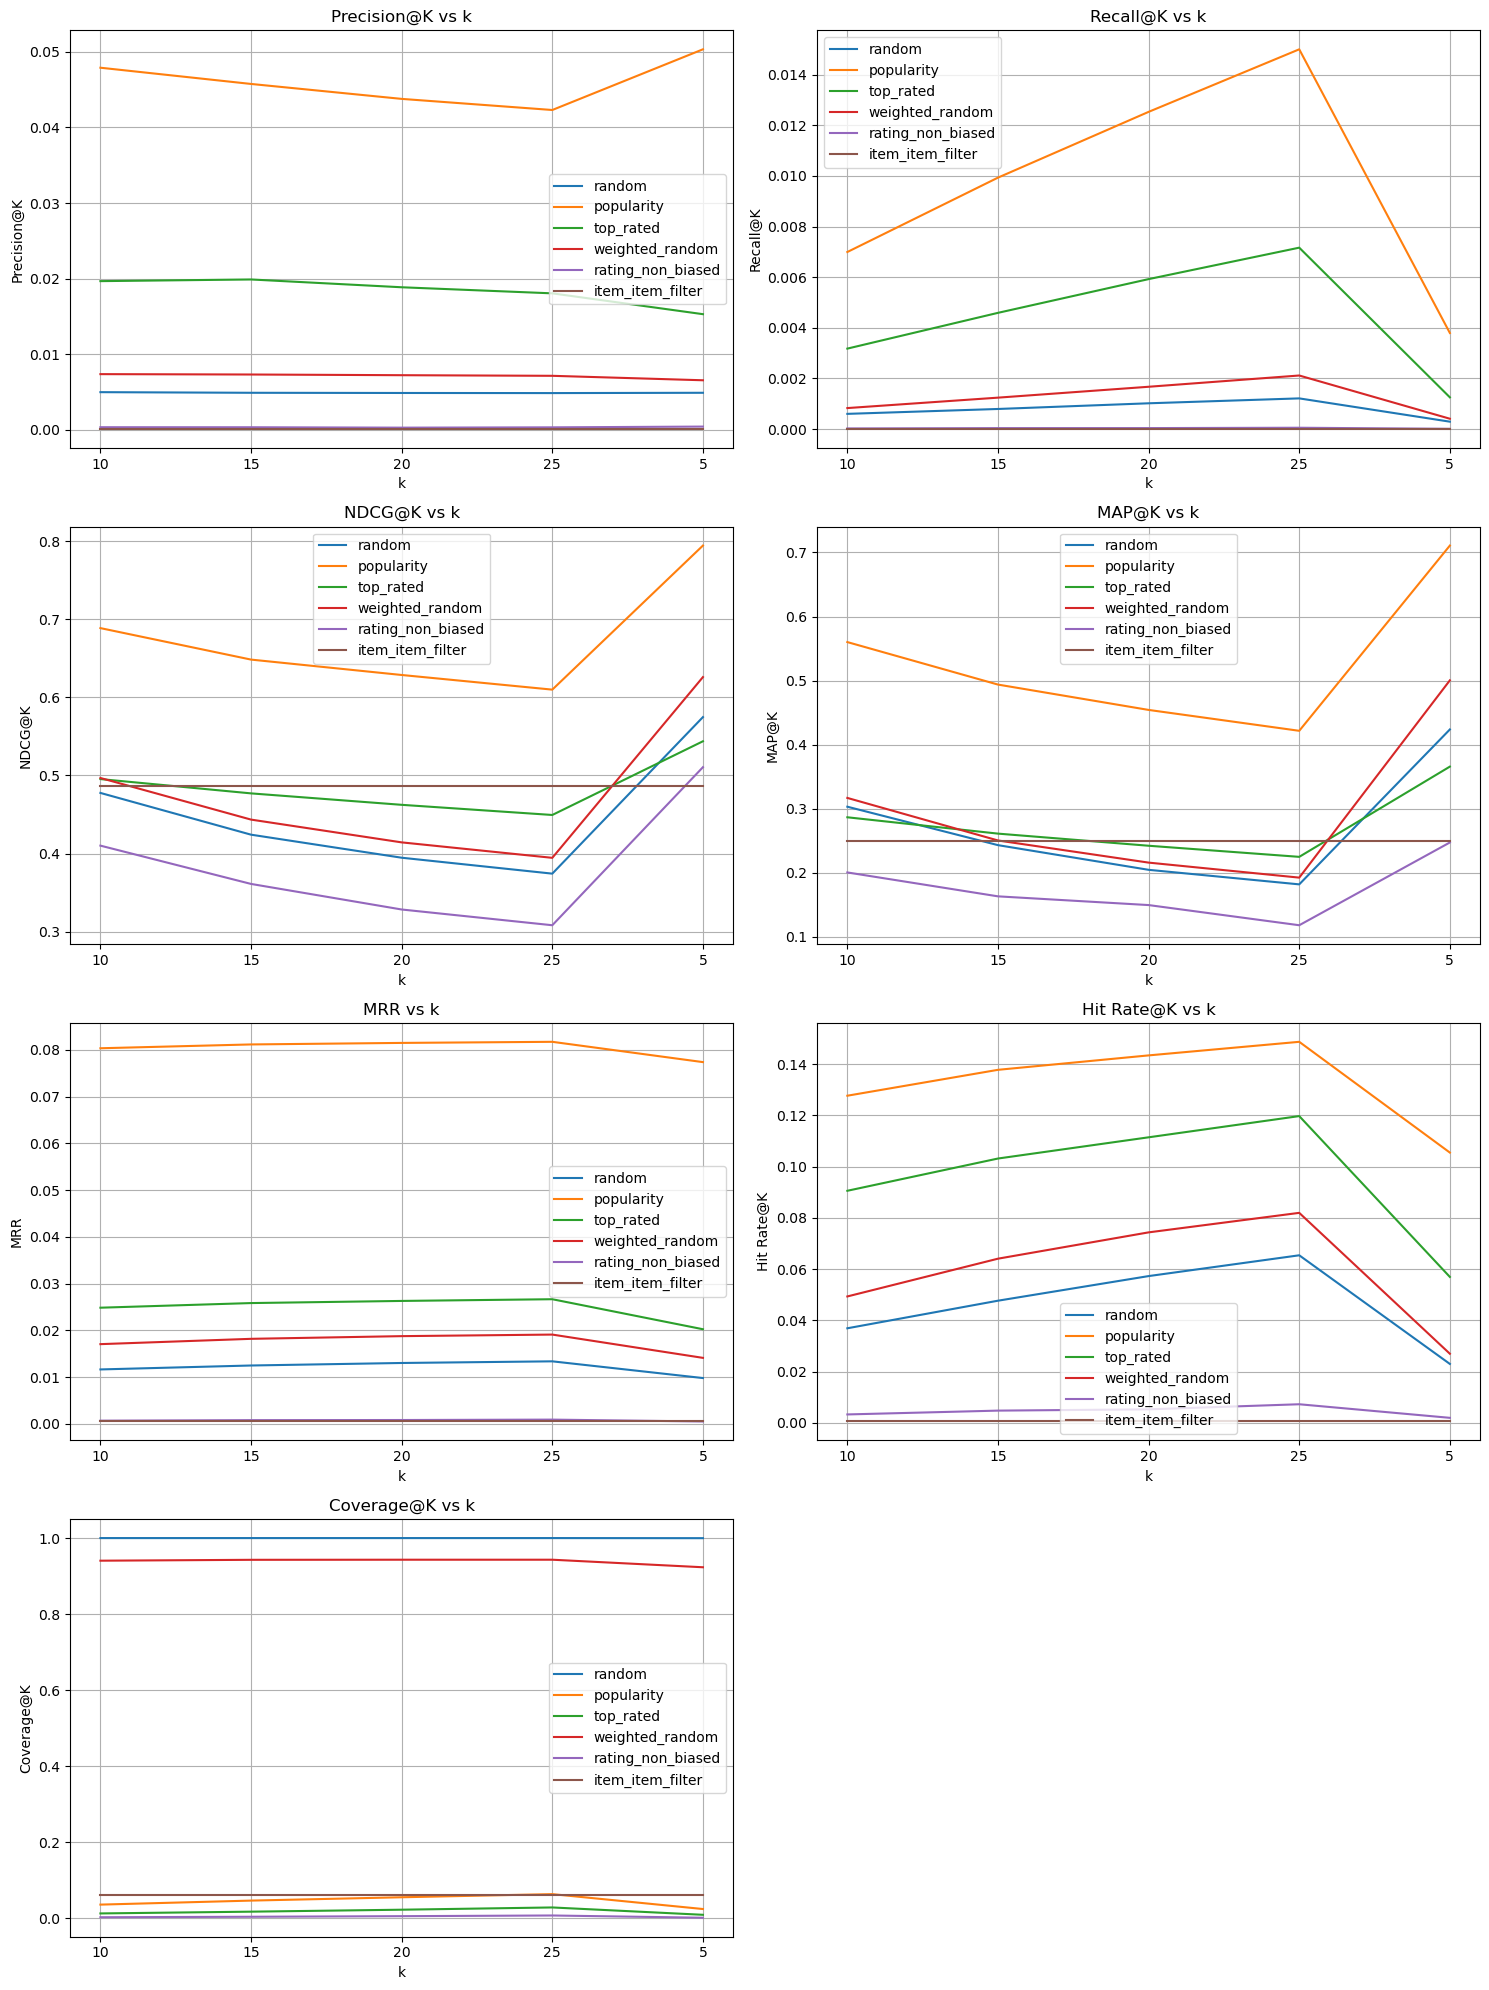

In [8]:
import sys

import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# add root folder to path
folder = "../../"
sys.path.append(folder)
from src.utils import load_data
from src.utils import plot_metrics_grid
from src.utils import load_baseline_rec_result
from src.metrics import evaluate_recommender_system

users, ratings, movies = load_data('../../data/ml-1m/')

# Split data into train and test by timestamp
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
split_point = int(len(ratings) * 0.8)
sorted_ratings = ratings.sort_values(by='timestamp')
train_ratings = sorted_ratings[:split_point]
test_ratings = sorted_ratings[split_point:]

item_user_matrix = train_ratings.pivot(index='movie_id', columns='user_id', values='rating')
item_user_matrix = item_user_matrix.fillna(0)

item_similarity = cosine_similarity(item_user_matrix)
item_similarity_df = pd.DataFrame(item_similarity, index=item_user_matrix.index, columns=item_user_matrix.index)


def get_item_recommendations(user_id, item_user_matrix, item_similarity_df, n_recommendations=10):
    if user_id not in item_user_matrix.columns:
        return []

    user_ratings = item_user_matrix.loc[:, user_id]
    weighted_ratings = item_similarity_df.dot(user_ratings)
    sum_of_similarities = item_similarity_df.dot(user_ratings > 0).replace(0, 1)  # Prevent division by zero
    weighted_ratings = weighted_ratings / sum_of_similarities
    already_rated = user_ratings > 0
    weighted_ratings = weighted_ratings[~already_rated]
    recommendations = weighted_ratings.sort_values(ascending=False).head(n_recommendations)
    recommended_movie_ids = recommendations.index

    return recommended_movie_ids


user_id = test_ratings['user_id'].iloc[0]
recommended_movies = get_item_recommendations(user_id, item_user_matrix, item_similarity_df)
print(movies[movies['movie_id'].isin(recommended_movies)][['title', 'genres']])

metrics_results = {}
base_line_metrics = load_baseline_rec_result()
for i in range(5, 26, 5):
    recommendations = {}
    for user_id in test_ratings['user_id'].unique():
        recommendations[user_id] = get_item_recommendations(user_id, item_user_matrix, item_similarity_df)
    metrics_results[str(i)] = evaluate_recommender_system(recommendations, test_ratings, len(movies))

combined = base_line_metrics | {'item_item_filter': metrics_results}
metrics = ['Precision@K', 'Recall@K', 'NDCG@K', 'MAP@K', 'MRR', 'Hit Rate@K', 'Coverage@K']
plot_metrics_grid(combined, metrics)